# Preprocessing and Training Data

In [1]:
# import necessary packages and load dataset

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate

import shap

In [2]:
df = pd.read_csv('../data/hotel_data_cleaned.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day,reservation_status_day_of_week,arrival_date_day_of_week
0,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015,7,2,Thursday,Wednesday
1,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015,7,2,Thursday,Wednesday
2,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015,7,3,Friday,Wednesday
3,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015,7,3,Friday,Wednesday
4,Resort Hotel,0,0,2015,7,27,1,0,2,2,...,Transient,107.0,0,0,Check-Out,2015,7,3,Friday,Wednesday


In [4]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                  int64
arrival_date_week_number            int64
arrival_date_day                    int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [5]:
# dropping target leakage variable

df=df.drop(columns='reservation_status')
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date_year,reservation_status_date_month,reservation_status_date_day,reservation_status_day_of_week,arrival_date_day_of_week
0,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,0,Transient,75.00,0,0,2015,7,2,Thursday,Wednesday
1,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,0,Transient,75.00,0,0,2015,7,2,Thursday,Wednesday
2,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,0,Transient,98.00,0,1,2015,7,3,Friday,Wednesday
3,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,0,Transient,98.00,0,1,2015,7,3,Friday,Wednesday
4,Resort Hotel,0,0,2015,7,27,1,0,2,2,...,0,Transient,107.00,0,0,2015,7,3,Friday,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116946,City Hotel,0,23,2017,8,35,30,2,5,2,...,0,Transient,96.14,0,0,2017,9,6,Wednesday,Wednesday
116947,City Hotel,0,102,2017,8,35,31,2,5,3,...,0,Transient,225.43,0,2,2017,9,7,Thursday,Thursday
116948,City Hotel,0,34,2017,8,35,31,2,5,2,...,0,Transient,157.71,0,4,2017,9,7,Thursday,Thursday
116949,City Hotel,0,109,2017,8,35,31,2,5,2,...,0,Transient,104.40,0,0,2017,9,7,Thursday,Thursday


## Transform categorical, text data

In [6]:
df1= pd.get_dummies(df, columns=['hotel','arrival_date_day_of_week','meal', 'country', 
                                 'market_segment', 'distribution_channel', 'reserved_room_type', 
                                 'assigned_room_type', 'deposit_type', 'customer_type',
                                 'reservation_status_day_of_week'], drop_first=False)
df1.shape

(116951, 260)

In [7]:
df.agent.value_counts()

9.0      31813
0.0      15231
240.0    13763
1.0       7050
14.0      3614
         ...  
352.0        1
480.0        1
451.0        1
165.0        1
472.0        1
Name: agent, Length: 332, dtype: int64

## Train/Test Split (Churn)

In [8]:
len(df1) * .7, len(df1) * .3

(81865.7, 35085.299999999996)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns='is_canceled'), 
                                                    df1.is_canceled, test_size=0.3, 
                                                    random_state=100)

In [10]:
X_train.shape, X_test.shape

((81865, 259), (35086, 259))

In [11]:
y_train.shape, y_test.shape

((81865,), (35086,))

# Classification Models 

1. Logistic Regression 
2. KNN 
3. SVM
4. Decision Tree
5. Gradient Boosting
6. Random Forest


### Logistic Regression

In [12]:
logreg= LogisticRegression()

logreg.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [13]:
prediction_log = logreg.predict(X_test)

In [14]:
print (confusion_matrix(y_test, prediction_log))
print (classification_report(y_test, prediction_log))

[[19966  1919]
 [ 8205  4996]]
              precision    recall  f1-score   support

           0       0.71      0.91      0.80     21885
           1       0.72      0.38      0.50     13201

    accuracy                           0.71     35086
   macro avg       0.72      0.65      0.65     35086
weighted avg       0.71      0.71      0.68     35086



Note for Logistic Regression

0 Precision represents the percent of your no-cancelled classifier 
1 Precision represents  cancelled prediction 

### KNN

In [15]:
# neighbors = np.arange(3, 5)
# train_accuracy = np.empty(len(neighbors))
# test_accuracy = np.empty(len(neighbors))

# for i, k in enumerate (neighbors):
#     print (k)
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train, y_train)
#     train_accuracy[i]=knn.score(X_train, y_train)
#     test_accuracy[i]=knn.score(X_test, y_test)

# plt.title('KNN: Varying Number of Neighbors')
# plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
# plt.plot(neighbors, train_accuracy, label='Training Accuracy')
# plt.legend()
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
# plt.show()


In [16]:
clf_knn = KNeighborsClassifier(n_neighbors=5)

clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

In [17]:
print (confusion_matrix(y_test, y_pred_knn))
print (classification_report(y_test, y_pred_knn))

[[20633  1252]
 [ 3414  9787]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     21885
           1       0.89      0.74      0.81     13201

    accuracy                           0.87     35086
   macro avg       0.87      0.84      0.85     35086
weighted avg       0.87      0.87      0.86     35086



### Linear SVM

In [18]:
clf_lsvm = LinearSVC()

clf_lsvm.fit(X_train, y_train)
y_pred_svm = clf_lsvm.predict(X_test)


Liblinear failed to converge, increase the number of iterations.


In [19]:
print (confusion_matrix(y_test, y_pred_svm))
print (classification_report(y_test, y_pred_svm))

[[19811  2074]
 [ 3846  9355]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     21885
           1       0.82      0.71      0.76     13201

    accuracy                           0.83     35086
   macro avg       0.83      0.81      0.81     35086
weighted avg       0.83      0.83      0.83     35086



### Decision Tree

In [20]:
# default params: gini, max_depth = None, min_samples_split = 2, min_samples_leaf = 1

clf_dt = tree.DecisionTreeClassifier(random_state = 47)

clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

In [21]:
print (confusion_matrix(y_test, y_pred_dt))
print (classification_report(y_test, y_pred_dt))

[[21089   796]
 [  893 12308]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21885
           1       0.94      0.93      0.94     13201

    accuracy                           0.95     35086
   macro avg       0.95      0.95      0.95     35086
weighted avg       0.95      0.95      0.95     35086



#### Feature Importance - Decision Tree

In [22]:
headers = ["name", "score"]
values_dt = sorted(zip(X_train.columns, clf_dt.feature_importances_), key=lambda x: x[1] * -1)
print('Feature Importance - Decision Tree')
print(tabulate(values_dt[:10], headers, tablefmt="plain"))

Feature Importance - Decision Tree
name                               score
deposit_type_Non Refund        0.231992
reservation_status_date_month  0.081724
arrival_date_week_number       0.0791298
market_segment_Online TA       0.0623794
lead_time                      0.0537492
total_of_special_requests      0.0481218
reservation_status_date_day    0.047269
country_PRT                    0.0410268
arrival_date_month             0.0355712
agent                          0.0332353


In [23]:
top50_feature_dt = [item[0] for item in values_dt[:50]]

In [24]:
X_train_dt=X_train[top50_feature_dt]
X_test_dt=X_test[top50_feature_dt]

In [25]:
clf_dt.fit(X_train_dt, y_train)

DecisionTreeClassifier(random_state=47)

In [26]:
y_pred3 = clf_dt.predict(X_test_dt)

In [27]:
print (confusion_matrix(y_test, y_pred3))
print (classification_report(y_test, y_pred3))

[[21061   824]
 [  845 12356]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21885
           1       0.94      0.94      0.94     13201

    accuracy                           0.95     35086
   macro avg       0.95      0.95      0.95     35086
weighted avg       0.95      0.95      0.95     35086



In [28]:
top100_feature_dt = [item[0] for item in values_dt[:100]]
X_train_dt=X_train[top100_feature_dt]
X_test_dt=X_test[top100_feature_dt]

In [29]:
clf_dt.fit(X_train_dt, y_train)
y_pred3 = clf_dt.predict(X_test_dt)

In [30]:
print (confusion_matrix(y_test, y_pred3))
print (classification_report(y_test, y_pred3))

[[21056   829]
 [  897 12304]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21885
           1       0.94      0.93      0.93     13201

    accuracy                           0.95     35086
   macro avg       0.95      0.95      0.95     35086
weighted avg       0.95      0.95      0.95     35086



In [31]:
top25_feature_dt = [item[0] for item in values_dt[:25]]
X_train_dt=X_train[top25_feature_dt]
X_test_dt=X_test[top25_feature_dt]

In [32]:
clf_dt.fit(X_train_dt, y_train)
y_pred3 = clf_dt.predict(X_test_dt)

In [33]:
print (confusion_matrix(y_test, y_pred3))
print (classification_report(y_test, y_pred3))

[[21047   838]
 [  884 12317]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21885
           1       0.94      0.93      0.93     13201

    accuracy                           0.95     35086
   macro avg       0.95      0.95      0.95     35086
weighted avg       0.95      0.95      0.95     35086



### Gradient Boosting

In [34]:
clf_gb = GradientBoostingClassifier(random_state = 47)

clf_gb.fit(X_train, y_train)
y_pred_gb = clf_gb.predict(X_test)

In [35]:
print (confusion_matrix(y_test, y_pred_gb))
print (classification_report(y_test, y_pred_gb))

[[20962   923]
 [ 2554 10647]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     21885
           1       0.92      0.81      0.86     13201

    accuracy                           0.90     35086
   macro avg       0.91      0.88      0.89     35086
weighted avg       0.90      0.90      0.90     35086



#### Feature Importance - Gradient Boosting

In [36]:
headers = ["name", "score"]
values_gb = sorted(zip(X_train.columns, clf_gb.feature_importances_), key=lambda x: x[1] * -1)
print('Feature Importance - Gradient Boosting')
print(tabulate(values_gb[:10], headers, tablefmt="plain"))

Feature Importance - Gradient Boosting
name                               score
deposit_type_Non Refund        0.340067
country_PRT                    0.0925429
lead_time                      0.0819307
market_segment_Online TA       0.0736457
total_of_special_requests      0.0588768
reservation_status_date_month  0.0367448
arrival_date_month             0.0328232
arrival_date_week_number       0.0306488
required_car_parking_spaces    0.0304181
previous_cancellations         0.0277206


### Random Forest

In [37]:
rf = RandomForestClassifier(random_state=47)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [38]:
print (confusion_matrix(y_test, y_pred_rf))
print (classification_report(y_test, y_pred_rf))

[[21654   231]
 [ 1461 11740]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21885
           1       0.98      0.89      0.93     13201

    accuracy                           0.95     35086
   macro avg       0.96      0.94      0.95     35086
weighted avg       0.95      0.95      0.95     35086



#### Feature Importance - RF

In [39]:
headers = ["name", "score"]
values_rf = sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1] * -1)
print('Feature Importance - Random Forest')
print(tabulate(values_rf[:10], headers, tablefmt="plain"))

Feature Importance - Random Forest
name                               score
lead_time                      0.0692112
deposit_type_Non Refund        0.062218
country_PRT                    0.0586881
reservation_status_date_month  0.0577651
deposit_type_No Deposit        0.049818
total_of_special_requests      0.0440357
arrival_date_week_number       0.0432837
adr                            0.0396664
reservation_status_date_day    0.0368257
arrival_date_month             0.0338692


In [40]:
# top 50 features 

top50_feature_rf = [item[0] for item in values_rf[:50]]

In [41]:
X_train_rf=X_train[top50_feature_rf]
X_test_rf=X_test [top50_feature_rf]

In [42]:
rf.fit(X_train_rf, y_train)

RandomForestClassifier(random_state=47)

In [43]:
y_pred2 = rf.predict(X_test_rf)

In [44]:
print (confusion_matrix(y_test, y_pred2))
print (classification_report(y_test, y_pred2))

[[21646   239]
 [ 1155 12046]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21885
           1       0.98      0.91      0.95     13201

    accuracy                           0.96     35086
   macro avg       0.96      0.95      0.96     35086
weighted avg       0.96      0.96      0.96     35086



In [45]:
# top 100 features

top100_feature_rf = [item[0] for item in values_rf[:100]]

In [46]:
X_train_rf=X_train[top100_feature_rf]
X_test_rf=X_test [top100_feature_rf]

In [47]:
rf.fit(X_train_rf, y_train)

RandomForestClassifier(random_state=47)

In [48]:
y_pred2 = rf.predict(X_test_rf)

In [49]:
# top 100 features

print (confusion_matrix(y_test, y_pred2))
print (classification_report(y_test, y_pred2))

[[21629   256]
 [ 1319 11882]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21885
           1       0.98      0.90      0.94     13201

    accuracy                           0.96     35086
   macro avg       0.96      0.94      0.95     35086
weighted avg       0.96      0.96      0.95     35086



In [50]:
# top 20

top20_feature_rf = [item[0] for item in values_rf[:20]]

In [51]:
X_train_rf=X_train[top20_feature_rf]
X_test_rf=X_test [top20_feature_rf]

In [52]:
rf.fit(X_train_rf, y_train)
y_pred2 = rf.predict(X_test_rf)

In [53]:
# top 20 features

print (confusion_matrix(y_test, y_pred2))
print (classification_report(y_test, y_pred2))

[[21717   168]
 [  951 12250]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     21885
           1       0.99      0.93      0.96     13201

    accuracy                           0.97     35086
   macro avg       0.97      0.96      0.97     35086
weighted avg       0.97      0.97      0.97     35086



### Refine the Decision Tree Model (Tuning Parameters)

In [54]:
param_grid_dt ={
    "criterion":['gini','entropy'],
    "max_depth":range(70, 200),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

In [55]:
# Randomized Search

random_dt = RandomizedSearchCV(clf_dt, param_distributions = param_grid_dt, cv=5, verbose=1, n_jobs=-1, n_iter=200)

random_dt.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 17.4min finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=47),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(70, 200),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 10)},
                   verbose=1)

In [56]:
random_dt.best_params_

{'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 136,
 'criterion': 'entropy'}

In [57]:
### Grid Search

In [58]:
param_grid ={
    "criterion":['gini','entropy'],
    "max_depth":range(140, 175),
    "min_samples_split":range(3,8),
    "min_samples_leaf":range(1,5)
}

In [59]:
grid_dt = GridSearchCV(clf_dt, param_grid = param_grid, cv=5, verbose=1, n_jobs=-1)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 83.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 96.6min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 111.5min
[Parallel(n_jobs=-1)]: Done 7000 out of 7000 | elapsed: 125.0min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=47), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(140, 175),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(3, 8)},
             verbose=1)

In [60]:
grid_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 140,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

#### implementing optimized parameters to Decision Tree Model


In [61]:
clf_dt2 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=140, 
                                     min_samples_leaf=1, min_samples_split=3, random_state=47)

clf_dt2.fit(X_train, y_train)
y_pred_dt2 = clf_dt2.predict(X_test)

In [62]:
print (confusion_matrix(y_test, y_pred_dt2))
print (classification_report(y_test, y_pred_dt2))

[[21166   719]
 [  823 12378]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     21885
           1       0.95      0.94      0.94     13201

    accuracy                           0.96     35086
   macro avg       0.95      0.95      0.95     35086
weighted avg       0.96      0.96      0.96     35086



In [114]:
headers = ["name", "score"]
values_dt = sorted(zip(X_train.columns, clf_dt2.feature_importances_), key=lambda x: x[1] * -1)
print('Feature Importance - Decision Tree (hyperparameter tuning)')
print(tabulate(values_dt[:15], headers, tablefmt="plain"))

Feature Importance - Decision Tree (hyperparameter tuning)
name                                       score
deposit_type_Non Refund                0.199373
arrival_date_week_number               0.0816116
market_segment_Online TA               0.0703453
reservation_status_date_month          0.0681787
reservation_status_date_day            0.0592259
lead_time                              0.0582863
arrival_date_month                     0.0481972
agent                                  0.0400916
total_of_special_requests              0.0379441
arrival_date_day                       0.0363977
country_PRT                            0.0313628
required_car_parking_spaces            0.0311332
arrival_date_year                      0.0228228
reservation_status_date_year           0.0220665
reservation_status_day_of_week_Sunday  0.017502


### Refine the Random Forest Model (Tuning Parameters)

In [64]:
param_grid_rf = {
    'max_depth':[100,200,None],
    'max_features':['sqrt', 'log2'],
    'n_estimators':[100,500,1000]
}


In [65]:
grid_rf = GridSearchCV(rf, param_grid = param_grid_rf, cv=5, verbose= 1, n_jobs=-1)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 61.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=47), n_jobs=-1,
             param_grid={'max_depth': [100, 200, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000]},
             verbose=1)

In [66]:
grid_rf.best_params_

{'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 1000}

In [67]:
rf2 = RandomForestClassifier(max_depth=100,max_features='sqrt',n_estimators=1000,random_state=47)
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

In [68]:
print (confusion_matrix(y_test, y_pred_rf2))
print (classification_report(y_test, y_pred_rf2))

[[21673   212]
 [ 1416 11785]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21885
           1       0.98      0.89      0.94     13201

    accuracy                           0.95     35086
   macro avg       0.96      0.94      0.95     35086
weighted avg       0.96      0.95      0.95     35086



In [69]:
headers = ["name", "score"]
values_dt = sorted(zip(X_train.columns, rf2.feature_importances_), key=lambda x: x[1] * -1)
print('Feature Importance - Random Forest (hyperparameter tuning)')
print(tabulate(values_dt[:10], headers, tablefmt="plain"))

Feature Importance - Random Forest (hyperparameter tuning)
name                               score
lead_time                      0.0682695
deposit_type_Non Refund        0.0604938
country_PRT                    0.0580207
deposit_type_No Deposit        0.056613
reservation_status_date_month  0.0554295
arrival_date_week_number       0.0434318
total_of_special_requests      0.0400311
adr                            0.0392294
reservation_status_date_day    0.0372967
arrival_date_day               0.0326452


In [70]:
# Class imbalance doesn't change the model much 

clf_dt3 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=140, 
                                     min_samples_leaf=1, min_samples_split=3, random_state=47,  class_weight={0:0.4,1:0.6})

clf_dt3.fit(X_train, y_train)
y_pred_dt3 = clf_dt3.predict(X_test)



In [71]:
print (confusion_matrix(y_test, y_pred_dt3))
print (classification_report(y_test, y_pred_dt3))

[[21126   759]
 [  791 12410]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     21885
           1       0.94      0.94      0.94     13201

    accuracy                           0.96     35086
   macro avg       0.95      0.95      0.95     35086
weighted avg       0.96      0.96      0.96     35086



In [72]:
# Class imbalance doesn't change the model

rf3 = RandomForestClassifier(max_depth=100,max_features='sqrt',n_estimators=1000,random_state=47, class_weight={0:0.4,1:0.6})
rf3.fit(X_train, y_train)
y_pred_rf3 = rf3.predict(X_test)

In [73]:
print (confusion_matrix(y_test, y_pred_rf3))
print (classification_report(y_test, y_pred_rf3))

[[21660   225]
 [ 1411 11790]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21885
           1       0.98      0.89      0.94     13201

    accuracy                           0.95     35086
   macro avg       0.96      0.94      0.95     35086
weighted avg       0.95      0.95      0.95     35086



Decision tree with criterion='entropy', max_depth=140, min_samples_leaf=1, min_samples_split=3, random_state=47

## Create SHAP Explainer & Compute SHAP values

In [74]:
X_train.shape, X_test.shape

((81865, 259), (35086, 259))

In [76]:
explainer = shap.TreeExplainer(clf_dt2, shap.sample(X_train,10000))
shap_values = explainer.shap_values(X_test)

100%|===================| 70165/70172 [62:07<00:00]        

## Global Interpretation - Feature Importance Globally

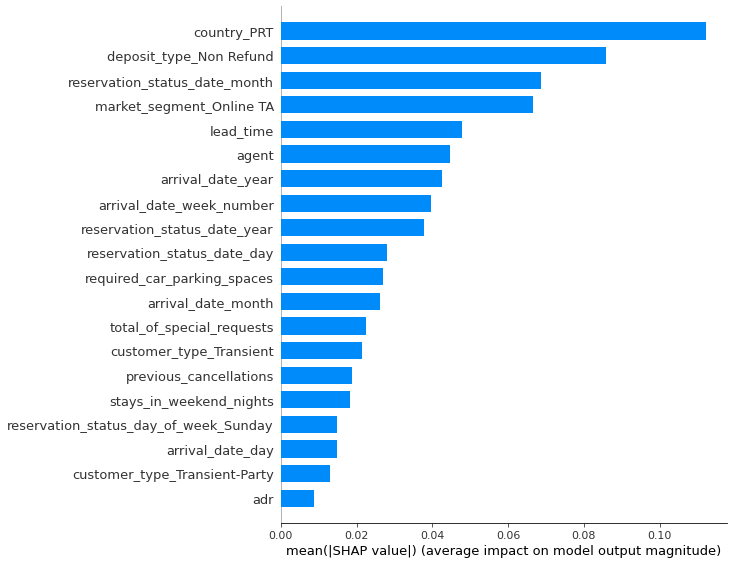

In [116]:
shap.summary_plot(shap_values[1], X_test, plot_type='bar')

In [101]:
explainer.expected_value[]

array([6.27950000e-001, 2.68678186e+154])

In [104]:
len(shap_values)

2

In [109]:
y_test.iloc[10]

1

In [110]:
y_pred_dt2[10]

1

In [111]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][10,:], X_test.iloc[10, :])

In [113]:
y_test.iloc[5], y_pred_dt2[5]

(0, 0)

In [112]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][5,:], X_test.iloc[5, :])

## Partial Dependence Plots

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


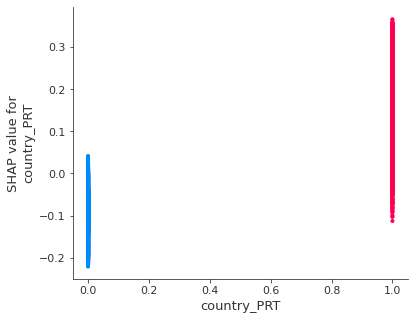

In [118]:
shap.dependence_plot(ind='country_PRT', interaction_index='country_PRT', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


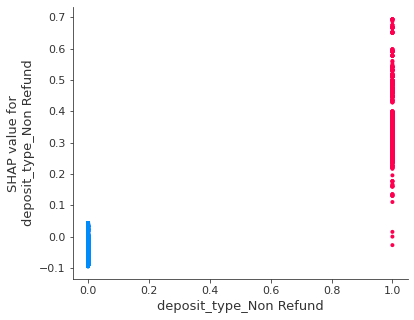

In [80]:
shap.dependence_plot(ind='deposit_type_Non Refund', interaction_index='deposit_type_Non Refund', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

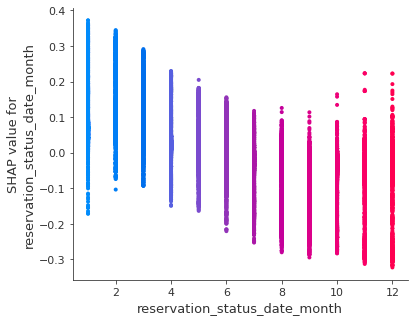

In [81]:
shap.dependence_plot(ind='reservation_status_date_month', interaction_index='reservation_status_date_month', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


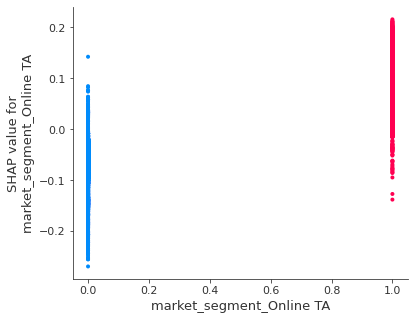

In [82]:
shap.dependence_plot(ind='market_segment_Online TA', interaction_index='market_segment_Online TA', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

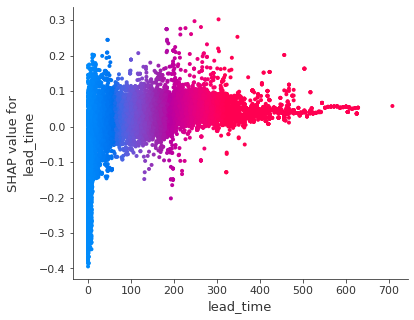

In [83]:
shap.dependence_plot(ind='lead_time', interaction_index='lead_time', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

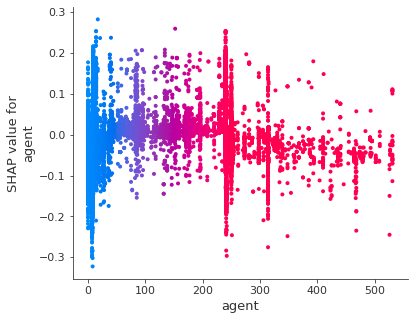

In [84]:
shap.dependence_plot(ind='agent', interaction_index='agent', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


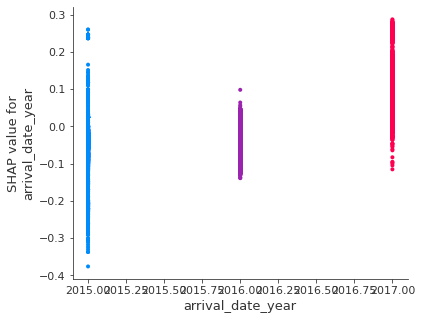

In [85]:
shap.dependence_plot(ind='arrival_date_year', interaction_index='arrival_date_year', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

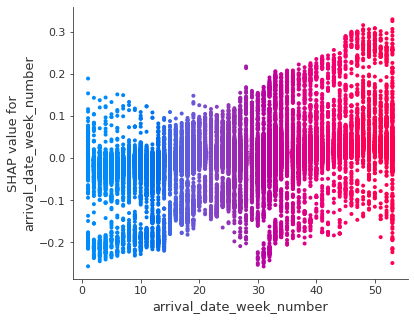

In [86]:
shap.dependence_plot(ind='arrival_date_week_number', interaction_index='arrival_date_week_number', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


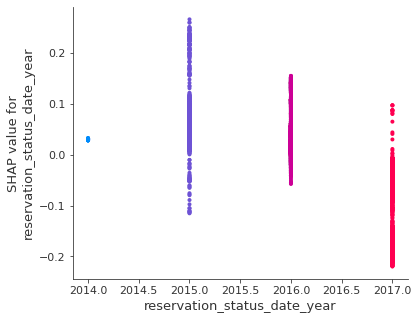

In [87]:
shap.dependence_plot(ind='reservation_status_date_year', interaction_index='reservation_status_date_year', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

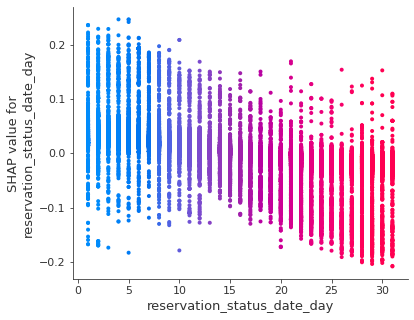

In [88]:
shap.dependence_plot(ind='reservation_status_date_day', interaction_index='reservation_status_date_day', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


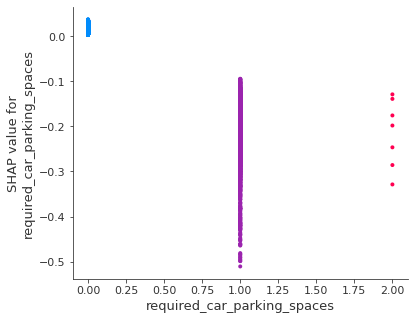

In [89]:
shap.dependence_plot(ind='required_car_parking_spaces', interaction_index='required_car_parking_spaces', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

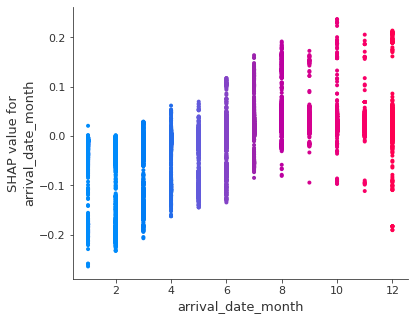

In [90]:
shap.dependence_plot(ind='arrival_date_month', interaction_index='arrival_date_month', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


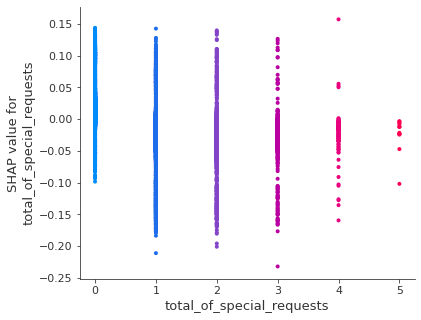

In [91]:
shap.dependence_plot(ind='total_of_special_requests', interaction_index='total_of_special_requests', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


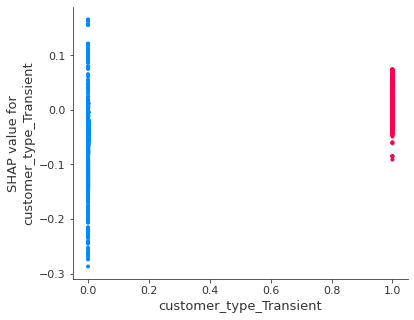

In [92]:
shap.dependence_plot(ind='customer_type_Transient', interaction_index='customer_type_Transient', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


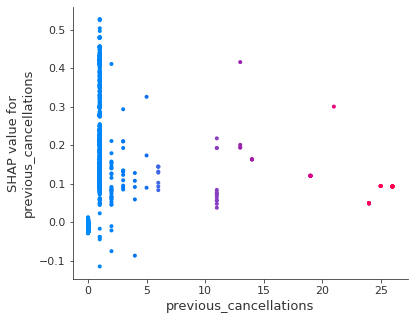

In [93]:
shap.dependence_plot(ind='previous_cancellations', interaction_index='previous_cancellations', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


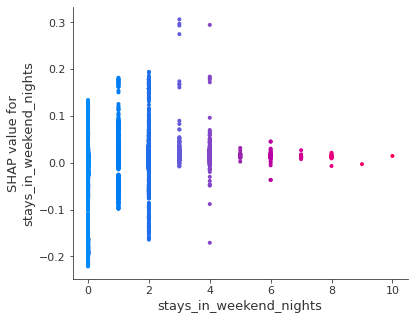

In [94]:
shap.dependence_plot(ind='stays_in_weekend_nights', interaction_index='stays_in_weekend_nights', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


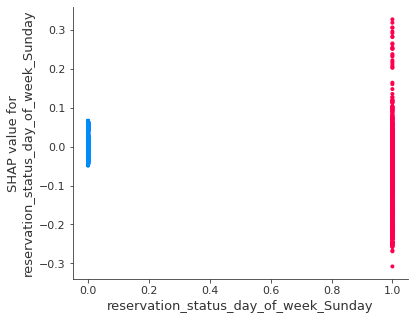

In [95]:
shap.dependence_plot(ind='reservation_status_day_of_week_Sunday', interaction_index='reservation_status_day_of_week_Sunday', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

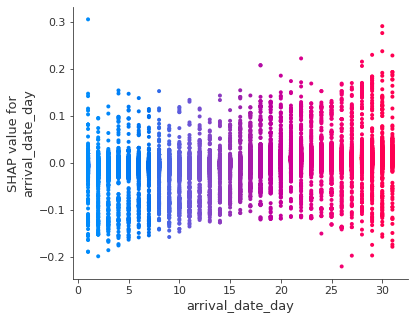

In [96]:
shap.dependence_plot(ind='arrival_date_day', interaction_index='arrival_date_day', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


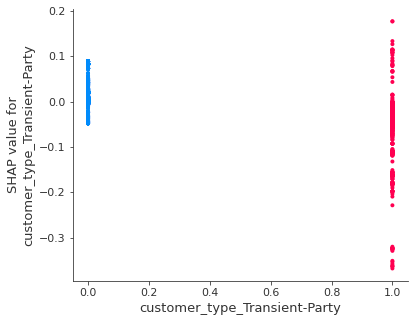

In [97]:
shap.dependence_plot(ind='customer_type_Transient-Party', interaction_index='customer_type_Transient-Party', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)

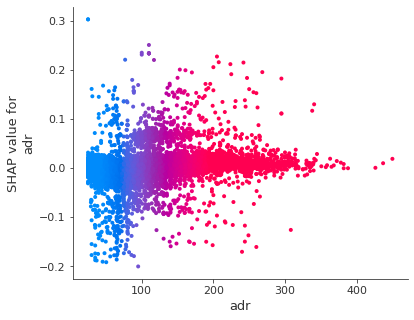

In [98]:
shap.dependence_plot(ind='adr', interaction_index='adr', 
                     shap_values = shap_values[1], 
                     features = X_test, 
                     display_features = X_test)